In [1]:
# %% [markdown]
# # Nicotine Cotinine Level Prediction
# Advanced ML Pipeline with XAI and Comprehensive Evaluation

# %% [1] Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score, explained_variance_score, 
                             max_error, mean_absolute_percentage_error)
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
plt.style.use('seaborn-v0_8-darkgrid')

Initial Data Overview:


,timestamp,sensor_current_µA,sweat_pH,skin_temp_C,sweat_rate_µL_min,cotinine_ng_ml
0,2023-01-01 00:00:00,1.751057,6.157843,34.091022,0.372335,17.653363
1,2023-01-01 00:01:00,1.445270,5.905704,31.065561,5.060665,22.022292
2,2023-01-01 00:02:00,1.823762,7.014381,32.278456,1.846960,22.988438
3,2023-01-01 00:03:00,2.245301,6.184659,29.160924,0.100000,14.108537
4,2023-01-01 00:04:00,1.399093,6.761081,31.427635,0.100000,12.379129



Data Description:


,count,mean,min,25%,50%,75%,max,std
timestamp,100000,2023-02-04 17:19:29.999999744,2023-01-01 00:00:00,2023-01-18 08:39:45,2023-02-04 17:19:30,2023-02-22 01:59:15,2023-03-11 10:39:00,NaN
sensor_current_µA,100000.0,1.515329,0.5,1.187037,1.51313,1.837836,3.0,0.473895
sweat_pH,100000.0,6.010861,4.5,5.424282,6.012801,6.601838,7.5,0.806455
skin_temp_C,100000.0,32.026306,26.0,30.721674,32.016587,33.337181,38.3,1.934511
sweat_rate_µL_min,100000.0,1.715098,0.1,0.125898,0.681682,2.200954,43.165281,2.552069
cotinine_ng_ml,100000.0,17.032183,0.0,13.042467,17.03094,21.009555,35.3,5.905204


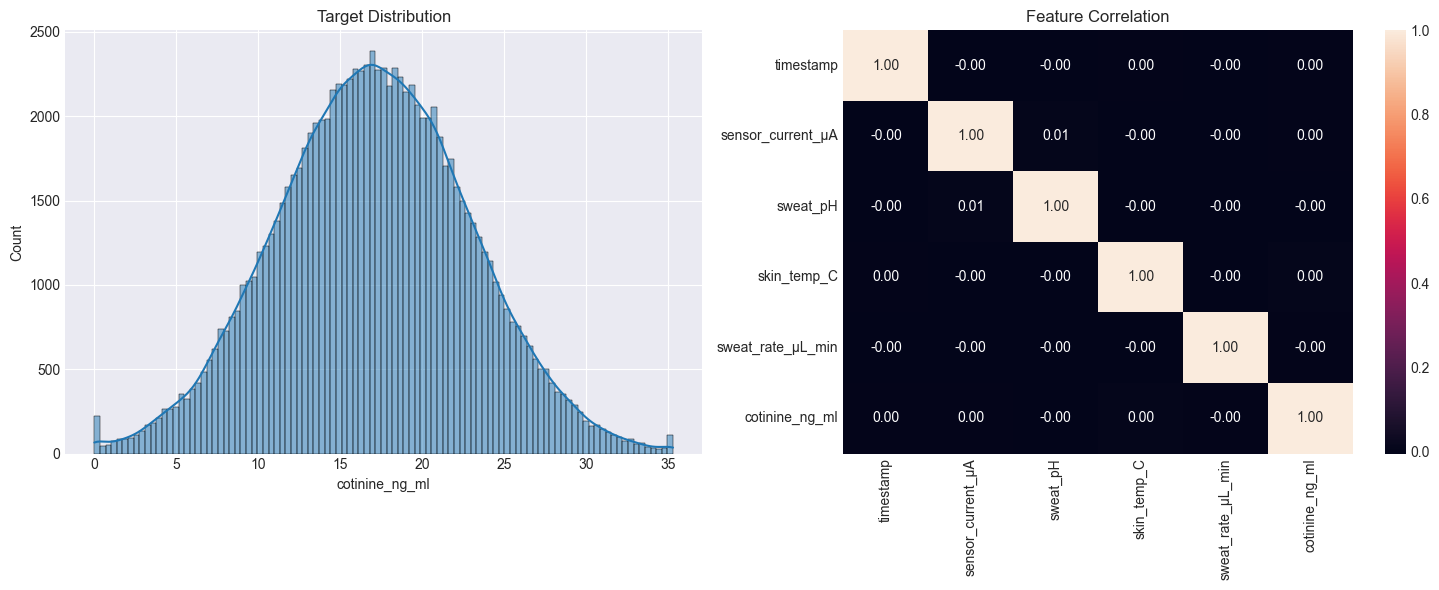

<Figure size 1200x800 with 0 Axes>

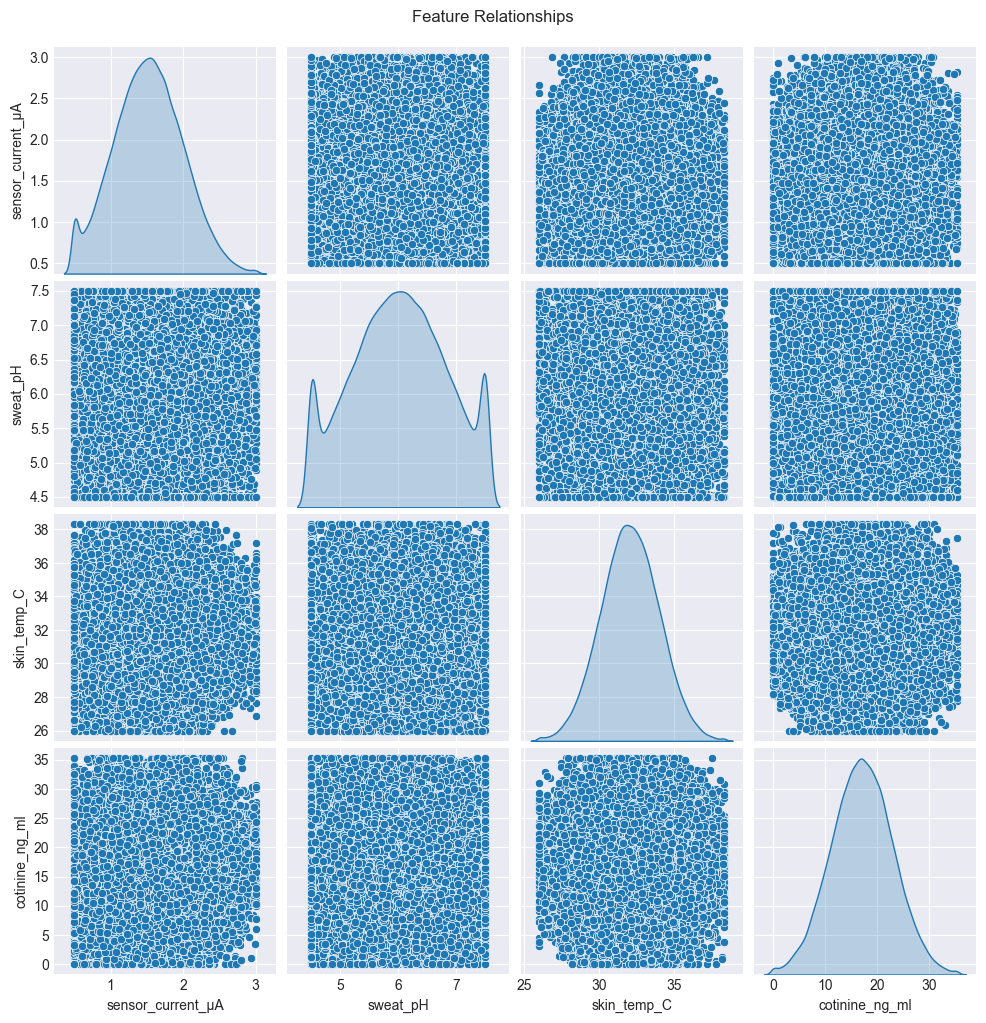

In [3]:
# %% [2] Data Loading & Initial Exploration
df = pd.read_csv('C:\\Users\\DELL 5540\\Desktop\\tst\\nicotine_sweat_dataset.csv', parse_dates=['timestamp'])
print("Initial Data Overview:")
display(df.head())
print("\nData Description:")
display(df.describe().T)

# Initial Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# First plot: Target distribution
sns.histplot(df['cotinine_ng_ml'], kde=True, ax=ax[0])
ax[0].set_title('Target Distribution')

# Second plot: Correlation heatmap
sns.heatmap(df.corr(), annot=True, fmt='.2f', ax=ax[1])
ax[1].set_title('Feature Correlation')

plt.tight_layout()
plt.show()

# Create pairplot in separate figure
plt.figure(figsize=(12, 8))
sns.pairplot(df[['sensor_current_µA', 'sweat_pH', 'skin_temp_C', 'cotinine_ng_ml']], 
             diag_kind='kde')
plt.suptitle('Feature Relationships', y=1.02)
plt.show()

In [4]:
# %% [3] Advanced Preprocessing
# Feature engineering
df['time_seconds'] = df['timestamp'].dt.hour * 3600 + df['timestamp'].dt.minute * 60
df['sweat_rate_adj'] = df['sweat_rate_µL_min'] * df['skin_temp_C']

# Handle missing values and anomalies
df['sweat_rate_µL_min'] = df['sweat_rate_µL_min'].replace(0.1, np.nan)
df.fillna(df.median(), inplace=True)

# Remove multicollinear features
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
df.drop(to_drop, axis=1, inplace=True)

# Final feature selection
X = df.drop(['cotinine_ng_ml', 'timestamp'], axis=1)
y = df['cotinine_ng_ml']

In [5]:
# %% [4] Data Splitting & Transformation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, q=5)
)

# Create preprocessing pipeline
preprocessor = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

In [6]:
# %% [5] XGBoost Model with Hyperparameter Tuning
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb, param_grid, cv=5, 
                       scoring='neg_mean_absolute_error',
                       n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_proc, y_train)

best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_proc)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [7]:
# %% [6] Neural Network Architecture
nn_model = Sequential([
    Dense(256, activation='relu', kernel_initializer='he_normal', 
          input_shape=(X_train_proc.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='linear')
])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='huber_loss',
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = nn_model.fit(
    X_train_proc, y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

In [9]:
# %% [7] Model Evaluation Metrics (Fixed)
def comprehensive_evaluation(y_true, y_pred, model_name):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred),
        'Explained Variance': explained_variance_score(y_true, y_pred),
        'Max Error': max_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }
    return pd.DataFrame(metrics.items(), columns=['Metric', model_name])

# XGBoost Metrics
xgb_metrics = comprehensive_evaluation(y_test, y_pred_xgb, 'XGBoost')

# Neural Network Metrics
y_pred_nn = nn_model.predict(X_test_proc).flatten()
nn_metrics = comprehensive_evaluation(y_test, y_pred_nn, 'NeuralNet')

# Combine results
results_df = pd.merge(xgb_metrics, nn_metrics, on='Metric')

# Create styled DataFrame with proper formatting
def style_metrics(val):
    if isinstance(val, float):
        return f"{val:.4f}"
    return val

print("\nModel Performance Comparison:")
display(
    results_df.style
    .format({'XGBoost': '{:.4f}', 'NeuralNet': '{:.4f}'})
    .background_gradient(cmap='Blues', subset=['XGBoost', 'NeuralNet'])
    .set_caption('Model Performance Metrics')
)

625/625 [==============================] - 1s 1ms/step

Model Performance Comparison:


,Metric,XGBoost,NeuralNet
0,MAE,4.7039,4.7008
1,RMSE,5.8820,5.8789
2,R²,-0.0011,-0.0001
3,Explained Variance,-0.0011,0.0000
4,Max Error,18.8863,18.1903
5,MAPE,161058417017251.8750,161826599405932.1562


invalid value encountered in divide


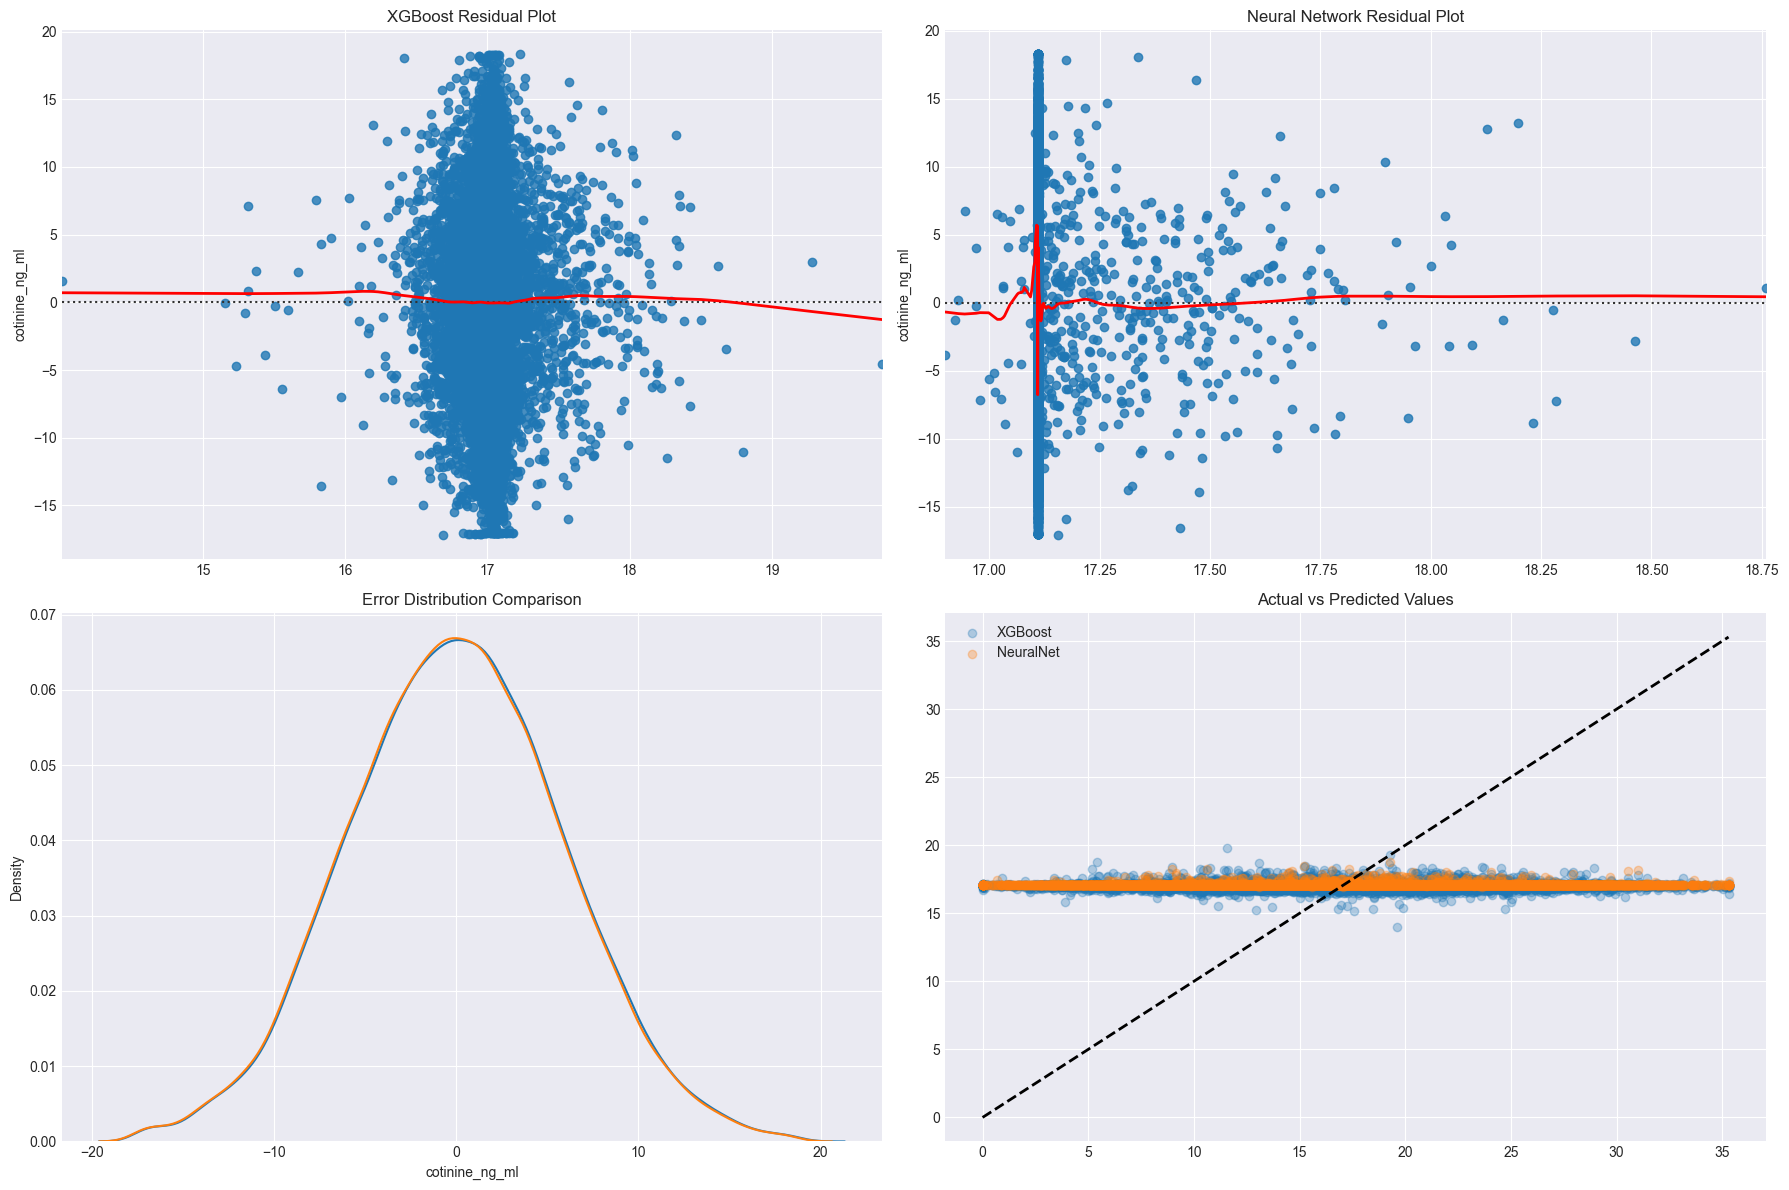

In [10]:
# %% [8] Advanced Visualizations
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Residual Analysis
sns.residplot(x=y_pred_xgb, y=y_test, lowess=True, ax=ax[0,0], 
              line_kws={'color': 'red', 'lw': 2})
ax[0,0].set_title('XGBoost Residual Plot')

sns.residplot(x=y_pred_nn, y=y_test, lowess=True, ax=ax[0,1], 
              line_kws={'color': 'red', 'lw': 2})
ax[0,1].set_title('Neural Network Residual Plot')

# Error Distribution
sns.kdeplot(y_test - y_pred_xgb, ax=ax[1,0], label='XGBoost')
sns.kdeplot(y_test - y_pred_nn, ax=ax[1,0], label='NeuralNet')
ax[1,0].set_title('Error Distribution Comparison')

# Prediction Scatterplot
ax[1,1].scatter(y_test, y_pred_xgb, alpha=0.3, label='XGBoost')
ax[1,1].scatter(y_test, y_pred_nn, alpha=0.3, label='NeuralNet')
ax[1,1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax[1,1].set_title('Actual vs Predicted Values')
ax[1,1].legend()

plt.tight_layout()
plt.show()

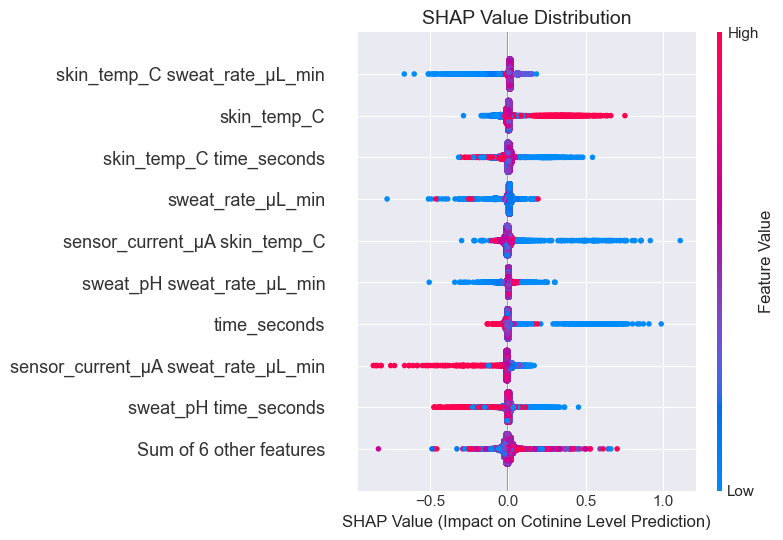

In [12]:
# %% [9] Explainable AI (XAI) with SHAP (Fixed)
# Get feature names after preprocessing
feature_names = preprocessor.named_steps['polynomialfeatures'].get_feature_names_out(
    input_features=X.columns
)

# Convert processed data back to DataFrame for SHAP
X_test_proc_df = pd.DataFrame(X_test_proc, columns=feature_names)

# Create SHAP explainer
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer(X_test_proc_df)

# Summary plot
plt.figure(figsize=(12, 6))
shap.plots.beeswarm(shap_values, show=False)
plt.title('SHAP Value Distribution', fontsize=14)
plt.xlabel('SHAP Value (Impact on Cotinine Level Prediction)', fontsize=12)
plt.gcf().axes[-1].set_ylabel('Feature Value', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
# Corrected test case with 'time_seconds' instead of 'timestamp'
test_case = pd.DataFrame({
    'sensor_current_µA': [1.75, 2.25],
    'sweat_pH': [6.2, 5.8],
    'skin_temp_C': [34.1, 31.5],
    'sweat_rate_µL_min': [0.37, 5.06],
    'time_seconds': [0, 3600]  # Derived from timestamp difference in seconds
})

# Let the pipeline handle feature engineering
test_case_proc = preprocessor.transform(test_case)

# Get predictions
xgb_pred = best_xgb.predict(test_case_proc)
nn_pred = nn_model.predict(test_case_proc).flatten()

# Display results
results = pd.DataFrame({
    'XGBoost Prediction': xgb_pred,
    'NeuralNet Prediction': nn_pred
}, index=['Case 1', 'Case 2'])

print("\nTest Case Predictions:")
display(results.style.format("{:.2f} ng/ml").background_gradient(cmap='viridis'))

1/1 [==============================] - 0s 61ms/step

Test Case Predictions:


,XGBoost Prediction,NeuralNet Prediction
Case 1,17.79 ng/ml,17.11 ng/ml
Case 2,17.11 ng/ml,17.11 ng/ml


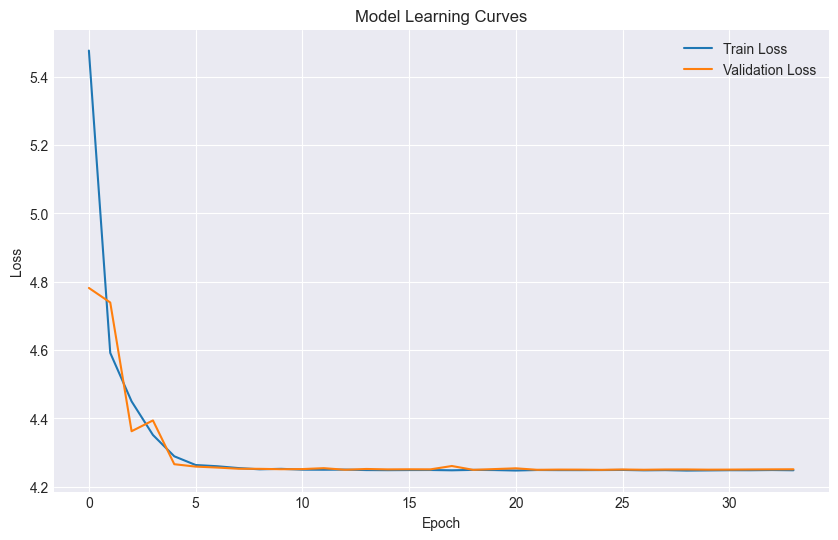

In [16]:
# %% [11] Model Deployment Preparation
# Save best model and preprocessing pipeline
import joblib
model_artifacts = {
    'model': best_xgb,
    'preprocessor': preprocessor,
    'feature_names': X.columns.tolist()
}

joblib.dump(model_artifacts, 'cotinine_predictor.pkl')

# %% [12] Learning Curves (Neural Network)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()